In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error


In [75]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import BatchNormalization

In [3]:
with open("../data/sim_data_162_1000_5.pkl","rb") as f:
    sim_data = pickle.load(f)

In [4]:
sim_data.shape

(162000, 5)

In [5]:
sim_data.head()

,pre_mean,pre1,pre2,pre3,y
12,227567.0,10103625.0,397843.0,167289.0,8259355.0
13,329525.0,8259355.0,10103625.0,397843.0,2742105.0
14,162264.0,2742105.0,8259355.0,10103625.0,2915779.0
15,79480.0,2915779.0,2742105.0,8259355.0,758981.0
16,29489.0,758981.0,2915779.0,2742105.0,143696.0


## Data:
The data has 1000 realizations from a mechanistic model, each has 162 data points, each has monthly incidence data from `2003-1~2017-6`.The inputs are previous 3 months, and the mean for previous same months. Output is the next month. <br>
I will use 800 for training and validation, 200 for test. <br>
I will use a batch size of 6 so that each batch contains realization from the same realization. 

## Data Preprocessing

In [6]:
np.argwhere(np.isnan(sim_data["pre_mean"]))

array([[ 77607],
       [113405]])

### reason
Only one previous month, which happens to be 0. Maybe better to take it out in the future. 

In [7]:
sim_data = sim_data.fillna(value=0)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
sim_data_scaled = scaler.fit_transform(sim_data)

In [9]:
type(sim_data_scaled)

numpy.ndarray

In [10]:
train_X, train_y = sim_data_scaled[:129600,:-1], sim_data_scaled[:129600,:1]
test_X, test_y = sim_data_scaled[129600:,:-1], sim_data_scaled[129600:,:1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(129600, 4) (129600, 1) (32400, 4) (32400, 1)


In [11]:
train_X, test_X = train_X.reshape(train_X.shape[0],1,train_X.shape[1]), test_X.reshape(test_X.shape[0],1,test_X.shape[1])
print(train_X.shape, test_X.shape)

(129600, 1, 4) (32400, 1, 4)


In [78]:
def train_lstm(n_ep = 20,va_split=None, vb = 0, drop=None, patience = None, l1 = None, l2 = None, batch_norm = None):
    # build model and train    
    neurons = 4
    batch_s = 1
    model = Sequential()
    model.add(LSTM(neurons,input_shape = (train_X.shape[1], train_X.shape[2])))
    if l1 !=None:
        model.add(Dense(10, kernel_regularizer=regularizers.l1(l1)))
    elif l2 != None:
        model.add(Dense(10, kernel_regularizer=regularizers.l2(l2)))
    else:
        model.add(Dense(10))
        
    if batch_norm != None:
        model.add(BatchNormalization())
    
    if drop != None:
        model.add(Dropout(drop))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer = "adam")
    
   
    
    if va_split != None:
        flu_fit = model.fit(train_X,train_y,epochs=n_ep, batch_size=162, 
                        validation_split=va_split,callbacks=[EarlyStopping(patience=patience)], verbose = vb)
        plt.plot(flu_fit.history["loss"][5:])
        plt.plot(flu_fit.history["val_loss"][5:])
        plt.show()
    else:
         flu_fit = model.fit(train_X,train_y,epochs=n_ep, batch_size=162,
                             verbose = vb)
    ## predict and analyze results
    flu_pred_train = model.predict(train_X, batch_size = 162)
    flu_pred_test = model.predict(test_X, batch_size = 162)

    train_X_shapeback = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    flu_pred_train_scaledback = scaler.inverse_transform(np.concatenate(
        (train_X_shapeback, flu_pred_train), axis = 1))
    flu_pred_train_scaledback = flu_pred_train_scaledback[:,-1]

    trainy_scaledback = scaler.inverse_transform(np.concatenate(
        (train_X_shapeback, train_y), axis = 1))
    trainy_scaledback = trainy_scaledback[:,-1]

    test_X_shapeback = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    flu_pred_test_scaledback = scaler.inverse_transform(np.concatenate(
        (test_X_shapeback, flu_pred_test), axis = 1))
    flu_pred_test_scaledback = flu_pred_test_scaledback[:,-1]

    testy_scaledback = scaler.inverse_transform(np.concatenate(
        (test_X_shapeback, test_y), axis = 1))
    testy_scaledback = testy_scaledback[:,-1]

    train_loss = sqrt(mean_squared_error(flu_pred_train_scaledback, trainy_scaledback))
    test_loss = sqrt(mean_squared_error(flu_pred_test_scaledback, testy_scaledback))
    print("Train loss "+ str(train_loss))
    print("Test loss "+ str(test_loss))

    flu_pred_test_scaledback = scaler.inverse_transform(np.concatenate(
        (train_X_shapeback, flu_pred_train), axis = 1))
    flu_pred_test_scaledback = flu_pred_test_scaledback[:,-1]

    plt.plot(flu_pred_train_scaledback[:144], color = "blue")
    plt.plot(trainy_scaledback[:144], color = "red")
    plt.show()

    plt.plot(flu_pred_test_scaledback[:144],color = "blue")
    plt.plot(testy_scaledback[:144],color = "red")
    plt.show()

Train loss 21304.53046358807
Test loss 22402.29379892489


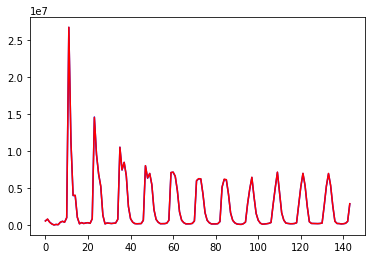

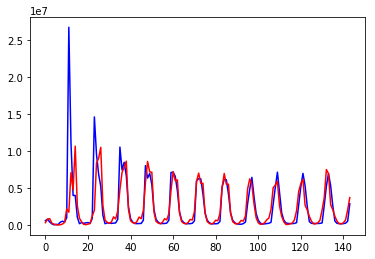

In [82]:
train_lstm(n_ep=5)

Train loss 18287.190136617086
Test loss 19755.66939212528


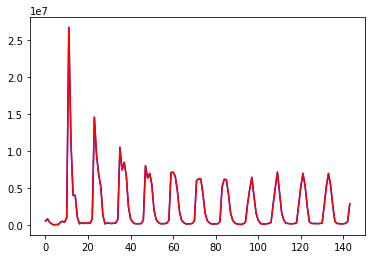

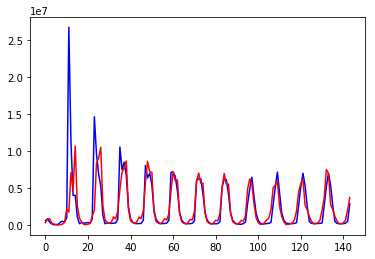

In [83]:
train_lstm(n_ep=10)

Train loss 13073.984157739398
Test loss 13637.95043361042


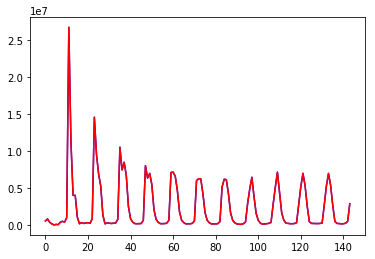

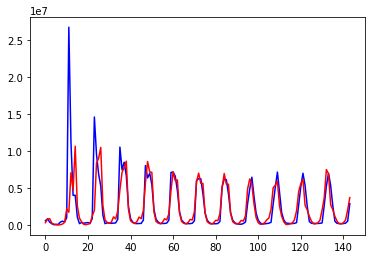

In [84]:
train_lstm()

Train loss 13057.334522467016
Test loss 14583.938302180186


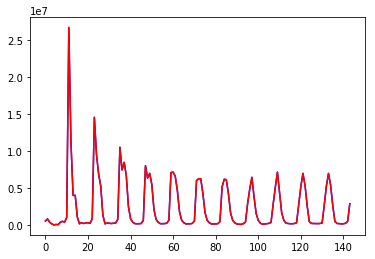

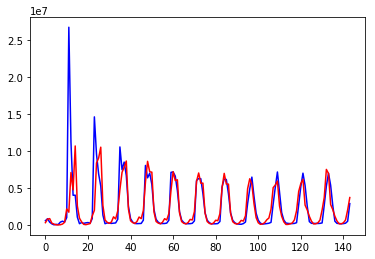

In [63]:
train_lstm()

# Dropout

Train loss 19210.59589251328
Test loss 20028.74140608349


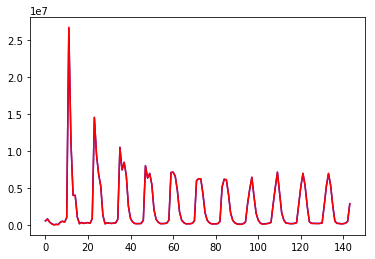

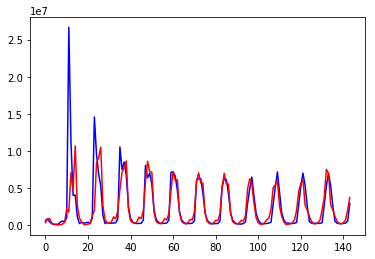

In [74]:
train_lstm(drop=0.001)

Train loss 13651.678119856537
Test loss 15569.141893023816


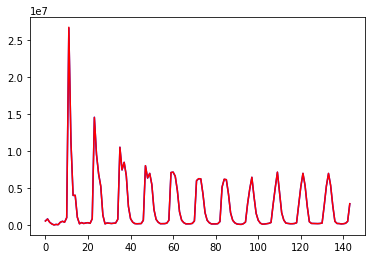

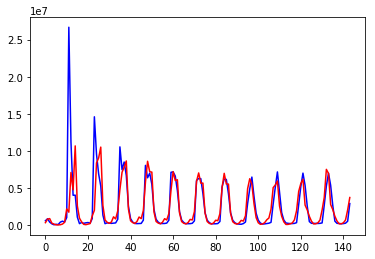

In [73]:
train_lstm(drop=0.0001)

Train loss 26696.01853049634
Test loss 28493.092051198306


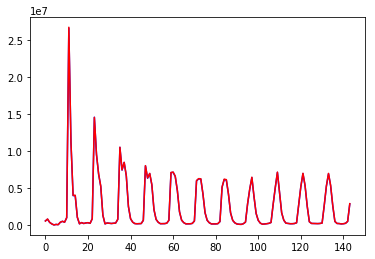

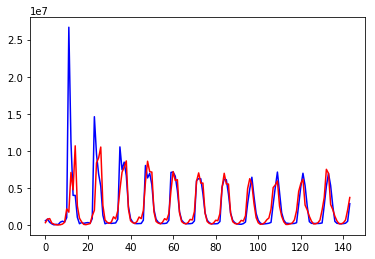

In [72]:
train_lstm(drop=0.01)

Train loss 33412.089612902535
Test loss 34480.98964674876


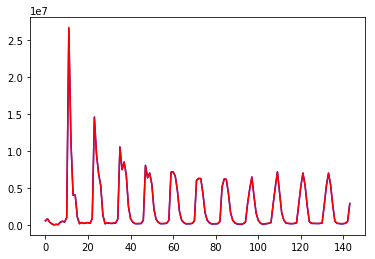

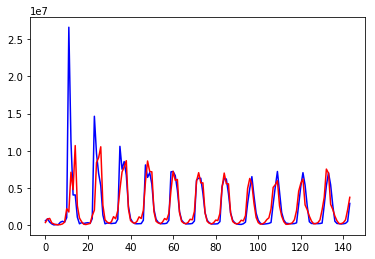

In [71]:
train_lstm(drop=0.1)

Train loss 132173.3075407454
Test loss 133114.727528032


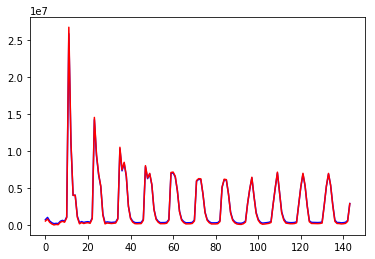

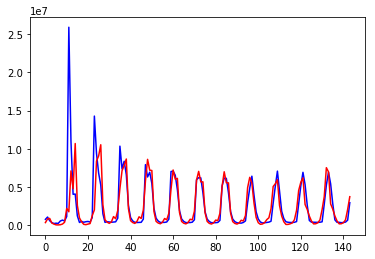

In [70]:
train_lstm(drop=0.2)

## Comment:
This is out baseline model. The training is better than the test, indicating that there might be the case of overfitting.

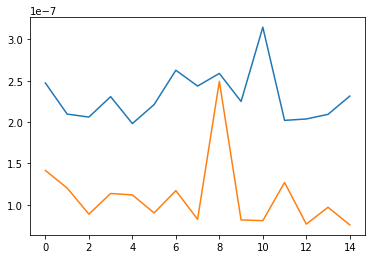

Train loss 16299.252009091339
Test loss 17592.458829932286


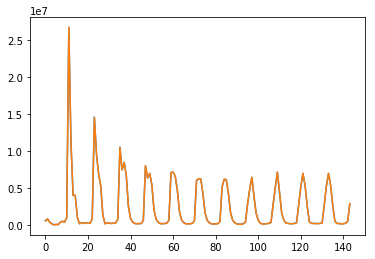

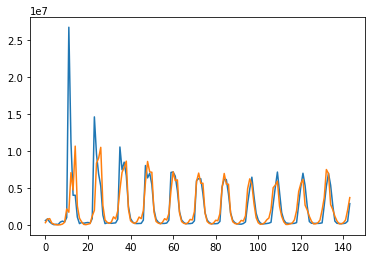

In [40]:
train_lstm(va_split=0.3)

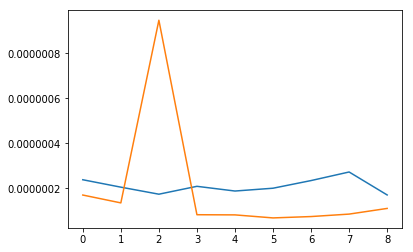

Train loss 18837.480671347406
Test loss 19413.945243860468


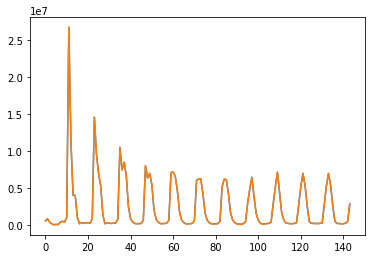

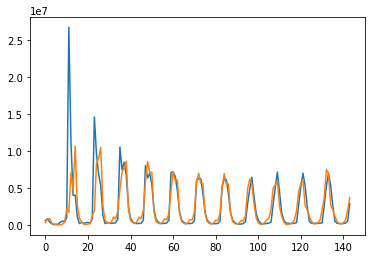

In [52]:
train_lstm(va_split=0.3, patience=3)

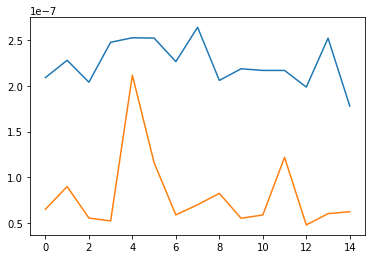

Train loss 17427.43410611623
Test loss 19477.889938178883


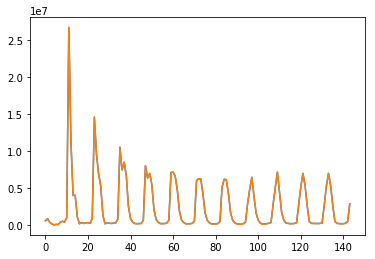

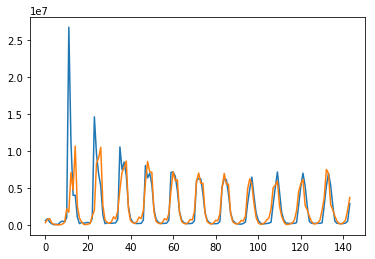

In [41]:
train_lstm(va_split=0.05)

## Comment:
Using Validationa and early stopping does not seem working here

# l1 regularization

Train loss 519570.59937285807
Test loss 585809.11238093


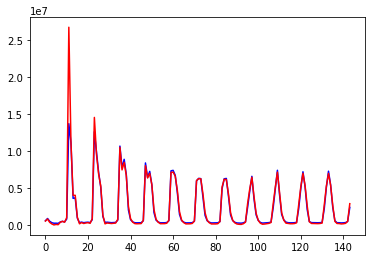

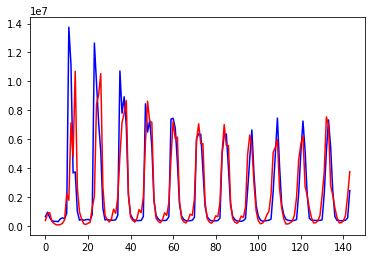

In [64]:
train_lstm(l1=0.01)

Train loss 276023.7844278262
Test loss 336087.6843401633


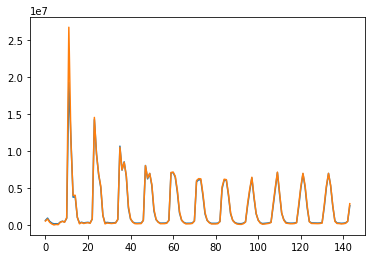

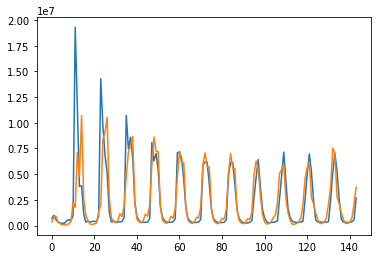

In [57]:
train_lstm(l1=0.001)

Train loss 138749.11716612347
Test loss 173392.26015196074


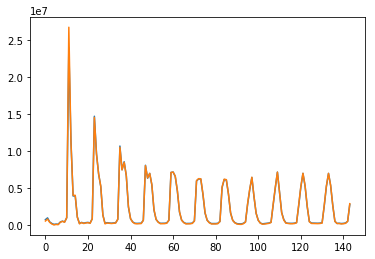

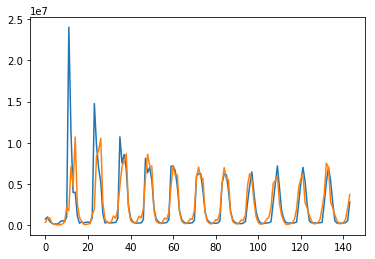

In [58]:
train_lstm(l1=0.0001)

Train loss 88157.0217260524
Test loss 98351.2723588362


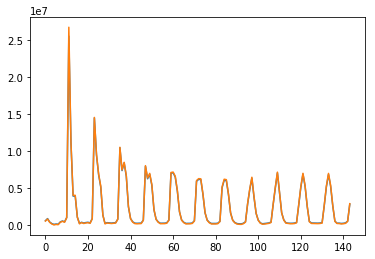

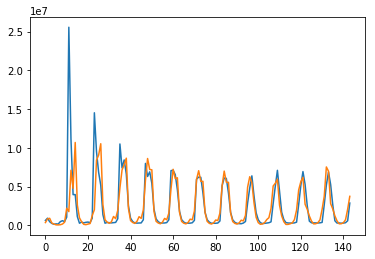

In [59]:
train_lstm(l1=0.00001)

Train loss 20188.59960911669
Test loss 22182.366742642163


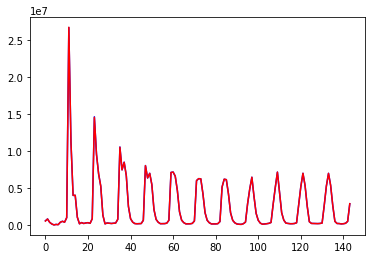

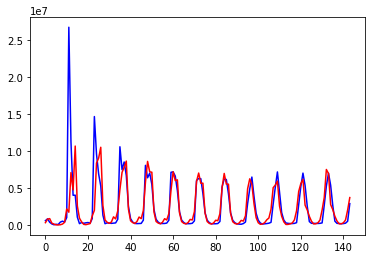

In [68]:
train_lstm(l1=0.0000001)

## Comment:
Adding l1 regularization has interesting results. On one hand, the bigger the regularization coefficient, the bigger the loss for both the training and the test. On the other hand, those with big loss not necessarily "look" bad. In the first case, the curve looks pretty cool, though the rmse loss is high. The problem is that it fails to capture the timing a little bit. This may be requiring us to use different loss functions! 

Train loss 170495.68620250796
Test loss 210898.29933453322


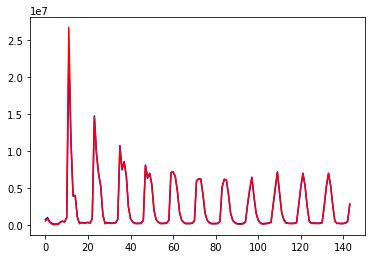

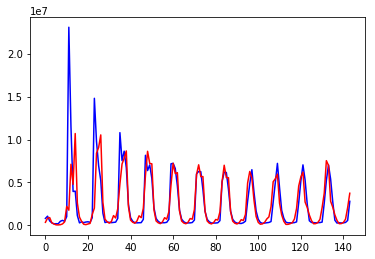

In [65]:
train_lstm(l2=0.01)

Train loss 52209.45656678682
Test loss 60320.432803621785


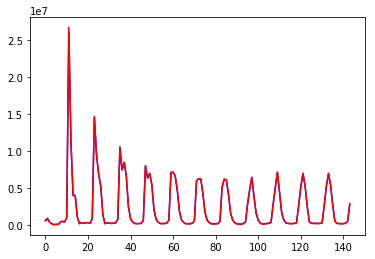

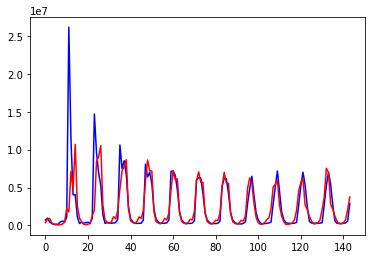

In [66]:
train_lstm(l2=0.0001)

Train loss 42375.843776232
Test loss 49119.73211272533


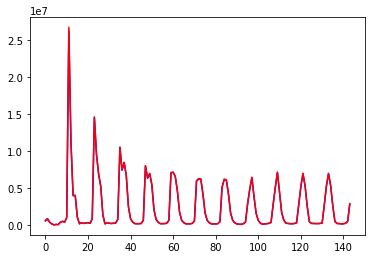

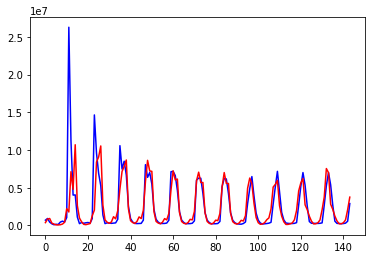

In [69]:
train_lstm(l2=0.00001)

Train loss 89022.48614718199
Test loss 89789.89231168249


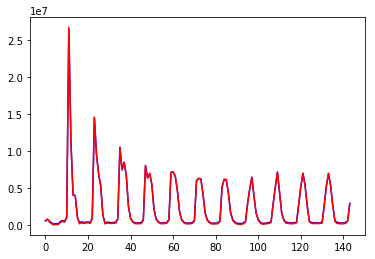

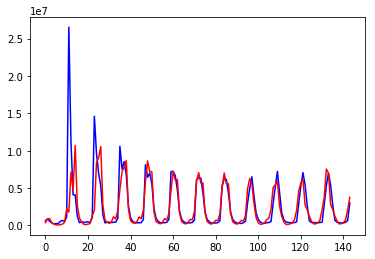

In [67]:
train_lstm(l2=0.000001)

## Comment:
L2 regularization not seems to work

# Batch_Normalization

Train loss 315288.0153439696
Test loss 315198.1788284034


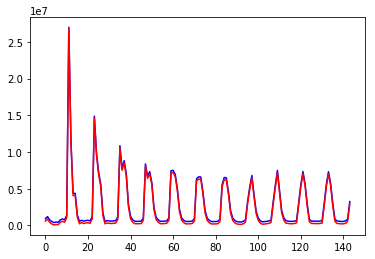

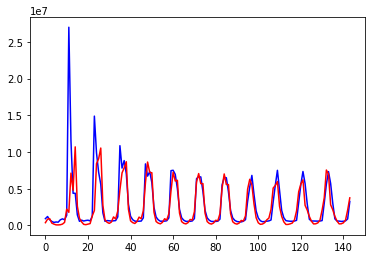

In [79]:
train_lstm(batch_norm=1)

Train loss 1567285.787461926
Test loss 1567185.938552242


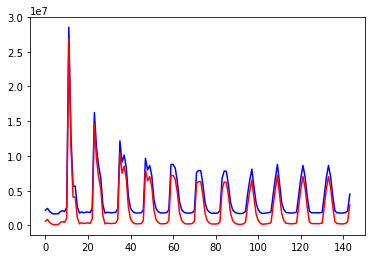

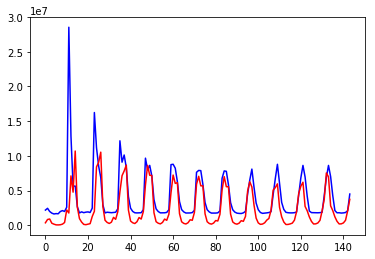

In [80]:
train_lstm(drop=0.001,batch_norm=1)

Train loss 48493.48392500347
Test loss 48653.47505868936


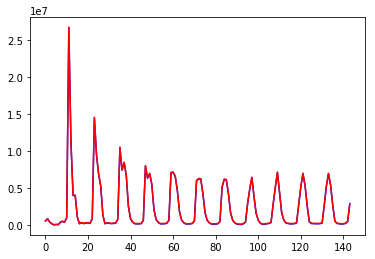

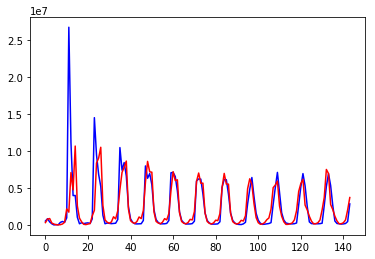

In [81]:
train_lstm(drop=0.0001,batch_norm=1)